In [1]:
%matplotlib inline
import openmc

In [2]:
# Create uranium di oxide at 3% enrichment and 10g/cm3
uo2 = openmc.Material(1,"uo2")
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)
print(uo2)

Material
	ID             =	1
	Name           =	uo2
	Temperature    =	None
	Density        =	10.0 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	U235           =	0.03         [ao]
	U238           =	0.97         [ao]
	O16            =	2.0          [ao]



In [3]:
# Create zirconium for cladding at 6.6 g/cm3
zirconium = openmc.Material(2, "zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)
print(zirconium)

Material
	ID             =	2
	Name           =	zirconium
	Temperature    =	None
	Density        =	6.6 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Zr90           =	0.5145       [ao]
	Zr91           =	0.1122       [ao]
	Zr92           =	0.1715       [ao]
	Zr94           =	0.1738       [ao]
	Zr96           =	0.028        [ao]



In [4]:
# Create water for moderator at 1.0 g/cm3
water = openmc.Material(3, "h2o")
water.add_nuclide('H1', 2.0)
water.add_element('O', 1.0)
water.set_density('g/cm3', 1.0)
# Add H s(a,b) cross sections for thermal neutron scattering
water.add_s_alpha_beta('c_H_in_H2O')
print(water)

Material
	ID             =	3
	Name           =	h2o
	Temperature    =	None
	Density        =	1.0 [g/cm3]
	S(a,b) Tables  
	S(a,b)         =	('c_H_in_H2O', 1.0)
	Nuclides       
	H1             =	2.0          [ao]
	O16            =	0.999621     [ao]
	O17            =	0.000379     [ao]



In [5]:
# Export marterials created to materials.xml
mats = openmc.Materials([uo2, zirconium, water])
mats.export_to_xml()
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <material id="1" name="uo2">
    <density units="g/cm3" value="10.0" />
    <nuclide ao="0.03" name="U235" />
    <nuclide ao="0.97" name="U238" />
    <nuclide ao="2.0" name="O16" />
  </material>
  <material id="2" name="zirconium">
    <density units="g/cm3" value="6.6" />
    <nuclide ao="0.5145" name="Zr90" />
    <nuclide ao="0.1122" name="Zr91" />
    <nuclide ao="0.1715" name="Zr92" />
    <nuclide ao="0.1738" name="Zr94" />
    <nuclide ao="0.028" name="Zr96" />
  </material>
  <material id="3" name="h2o">
    <density units="g/cm3" value="1.0" />
    <nuclide ao="2.0" name="H1" />
    <nuclide ao="0.999621" name="O16" />
    <nuclide ao="0.000379" name="O17" />
    <sab name="c_H_in_H2O" />
  </material>
</materials>


In [6]:
# Create surfaces for uranium cylinder
fuel_or = openmc.ZCylinder(R=0.39)
fuel_top = openmc.ZPlane(z0=49)
fuel_bottom = openmc.ZPlane(z0=-49)

# Create surfaces for cladding cylinder, cap, and tip
clad_ir = openmc.ZCylinder(R=0.40)
clad_or = openmc.ZCylinder(R=0.46)
clad_tip_r = openmc.ZCylinder(R=0.26)
clad_cap_top = openmc.ZPlane(z0=60)
clad_tip_top = openmc.ZPlane(z0=65)
clad_cap_bottom = openmc.ZPlane(z0=-60)
clad_tip_bottom = openmc.ZPlane(z0=-65)

# Crate top and bottom surfaces for gap between fuel and cladding
gap_top = openmc.ZPlane(z0=50)
gap_bottom = openmc.ZPlane(z0=-50)

# Create a cylinder to bound the surface of the moderator around the pin cell
pitch = 1.26
back = openmc.XPlane(x0=-pitch/2, boundary_type='vacuum')
front = openmc.XPlane(x0=pitch/2, boundary_type='vacuum')
left = openmc.YPlane(y0=-pitch/2, boundary_type='vacuum')
right = openmc.YPlane(y0=pitch/2, boundary_type='vacuum')
top = openmc.ZPlane(z0=75, boundary_type='vacuum')
bottom = openmc.ZPlane(z0=-75, boundary_type='vacuum')

In [7]:
# Create a region for the fuel in a cylinder
fuel_region = -fuel_or & +fuel_bottom & -fuel_top

# Create regions for the cladding cylinder, caps, and tips
clad_region_cyl = +clad_ir & -clad_or & +gap_bottom & -gap_top
clad_region_cap_top = +gap_top & -clad_cap_top & -clad_or
clad_region_cap_bottom = -gap_bottom & +clad_cap_bottom & -clad_or
clad_region_tip_top = +clad_cap_top & -clad_tip_top & -clad_tip_r
clad_region_tip_bottom = -clad_cap_bottom & +clad_tip_bottom & -clad_tip_r

# Create a region for the gap between the cladding and the fuel
gap_region_cyl = +fuel_or & -clad_ir & +fuel_bottom & -fuel_top 
gap_region_top = +fuel_top & -gap_top & -clad_ir
gap_region_bottom = -fuel_bottom & +gap_bottom & -clad_ir

In [8]:
# Create regions for the water along each horizontal area with different cladding regions
water_region_r = +left & -right & +back & -front & -clad_cap_top & +clad_cap_bottom & +clad_or
water_region_tip_t = +left & -right & +back & -front & +clad_cap_top & -clad_tip_top & +clad_tip_r
water_region_tip_b = +left & -right & +back & -front & -clad_cap_bottom & +clad_tip_bottom & +clad_tip_r
water_region_t = +left & -right & +back & -front & +clad_tip_top & -top
water_region_b = +left & -right & +back & -front & -clad_tip_bottom & +bottom

In [9]:
# Create a fuel cell with uranium dioxide material
fuel = openmc.Cell(1, 'fuel')
fuel.fill = uo2
fuel.region = fuel_region

In [10]:
# Create a gap cell with void material
gap = openmc.Cell(2, 'air gap')
gap.region = gap_region_cyl | gap_region_top | gap_region_bottom

In [11]:
# Create a clad cell with zirconium material
clad = openmc.Cell(3, 'clad')
clad.fill = zirconium
clad.region = clad_region_cyl | clad_region_cap_top | clad_region_cap_bottom | clad_region_tip_top | clad_region_tip_bottom

In [12]:
# Create a moderator cell with water material
moderator = openmc.Cell(4, 'moderator')
moderator.fill = water
moderator.region = water_region_r | water_region_tip_t | water_region_tip_b | water_region_t | water_region_b

In [13]:
# Create a root universe and export the geometry to geometry.xml
root = openmc.Universe(cells=(fuel, gap, clad, moderator))
geom = openmc.Geometry(root)
geom.export_to_xml()
!cat geometry.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <cell id="1" material="1" name="fuel" region="-1 3 -2" universe="1" />
  <cell id="2" material="void" name="air gap" region="(1 -4 3 -2) | (2 -11 -4) | (-3 12 -4)" universe="1" />
  <cell id="3" material="2" name="clad" region="(4 -5 12 -11) | (11 -7 -5) | (-12 9 -5) | (7 -8 -6) | (-9 10 -6)" universe="1" />
  <cell id="4" material="3" name="moderator" region="(15 -16 13 -14 -7 9 5) | (15 -16 13 -14 7 -8 6) | (15 -16 13 -14 -9 10 6) | (15 -16 13 -14 8 -17) | (15 -16 13 -14 -10 18)" universe="1" />
  <surface coeffs="0.0 0.0 0.39" id="1" type="z-cylinder" />
  <surface coeffs="49" id="2" type="z-plane" />
  <surface coeffs="-49" id="3" type="z-plane" />
  <surface coeffs="0.0 0.0 0.4" id="4" type="z-cylinder" />
  <surface coeffs="0.0 0.0 0.46" id="5" type="z-cylinder" />
  <surface coeffs="0.0 0.0 0.26" id="6" type="z-cylinder" />
  <surface coeffs="60" id="7" type="z-plane" />
  <surface coeffs="65" id="8" type="z-plane" />
  <surfac

In [14]:
# Set openmc to run 100 batches of 1000 cells with 20 batches not changing the average
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 20
settings.particles = 1000

In [15]:
# Export settings to settings.xml
settings.export_to_xml()
!cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<settings>
  <run_mode>eigenvalue</run_mode>
  <particles>1000</particles>
  <batches>100</batches>
  <inactive>20</inactive>
</settings>


In [16]:
# Run openmc
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

In [17]:
# Create plot of the pin cell in the xz plane
p1 = openmc.Plot()
p1.basis = 'xz'
p1.filename = 'pinplot_xz'
p1.width = (-1.26,150)
p1.pixels = (500, 500)
p1.color_by = 'material'
p1.colors = {uo2: 'yellow', water: 'blue'}
plots = openmc.Plots([p1])
plots.export_to_xml()
openmc.plot_geometry(output=False)

0

In [18]:
# Create plot of the pin cell in the xy plane
p2 = openmc.Plot()
p2.basis = 'xy'
p2.filename = 'pinplot_xy'
p2.width = (-1.26,1.26)
p2.pixels = (200, 200)
p2.color_by = 'material'
p2.colors = {uo2: 'yellow', water: 'blue'}
plots = openmc.Plots([p2])
plots.export_to_xml()
openmc.plot_geometry(output=False)

0

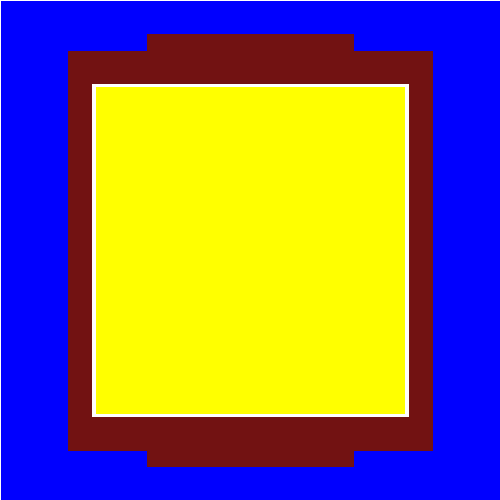

In [19]:
# Show plot of xy plane
# Plot is squished due to odd dimensions
openmc.plot_inline(p1)

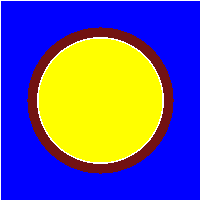

In [20]:
# Show plot of xy plane
openmc.plot_inline(p2)